In [1]:
## We will look at a Linear regression model for predicting Default Rates of bank loans using macro economic factors
## and a second linear regression for default rates of cedit card debt using macro economic factors
## Data for defualt rates extracted from https://www.federalreserve.gov/releases/chargeoff/default.htm
## Data for macro economic factors extracted from https://www.fhfa.gov

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn import metrics
import statsmodels.api as sm
import random

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline

## I removed all rows of data containing null or nan values. 
df = pd.read_csv('Desktop\\StressTesting\\DelinquencyRates.csv')

# Load the data
#Explore data, view the first few rows
df.head()
print(df.shape)
#Get some statistics from our data set, count, mean standard deviation etc.
print(df.info())
df.describe()

(114, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 15 columns):
Date                       114 non-null object
Residential_REIT_Loans     114 non-null float64
Commercial_REIT_Loans      114 non-null float64
Credit_Cards               114 non-null float64
Other_Consumer_Loans       114 non-null float64
Commercial_Indust_Loans    114 non-null float64
Total_Loans                114 non-null float64
Real_GDP_growth            114 non-null float64
Unemployment_Rate          114 non-null float64
CPI_Inflation_Rate         114 non-null float64
FiveYr_Treasury_Yield      114 non-null float64
10yrTreasuryYield          114 non-null float64
BBB_Corporate_Yield        114 non-null float64
Prime_Rate                 114 non-null float64
Dow_Jones_Index            114 non-null float64
dtypes: float64(14), object(1)
memory usage: 13.4+ KB
None


,Residential_REIT_Loans,Commercial_REIT_Loans,Credit_Cards,Other_Consumer_Loans,Commercial_Indust_Loans,Total_Loans,Real_GDP_growth,Unemployment_Rate,CPI_Inflation_Rate,FiveYr_Treasury_Yield,10yrTreasuryYield,BBB_Corporate_Yield,Prime_Rate,Dow_Jones_Index
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,4.125965,3.556053,3.972018,2.690175,2.312632,3.164474,2.510526,5.885965,2.309649,3.872807,4.555263,6.300877,5.780702,12862.332456
std,3.013472,3.103721,1.116757,0.482488,1.340347,1.619698,2.323385,1.606892,1.841650,2.017327,1.821994,1.573480,2.142692,6725.707437
min,1.410000,0.680000,2.120000,1.820000,0.730000,1.500000,-8.200000,3.800000,-8.900000,0.700000,1.600000,3.700000,3.300000,3545.500000
25%,2.110000,1.340000,2.955000,2.330000,1.310000,2.140000,1.450000,4.700000,1.825000,2.025000,2.825000,4.825000,3.500000,8356.625000
50%,2.625000,1.980000,4.135000,2.740000,1.960000,2.470000,2.700000,5.500000,2.400000,3.850000,4.400000,6.500000,5.350000,11763.900000
75%,5.245000,4.957500,4.727500,3.047500,2.962500,4.072500,3.875000,6.875000,3.275000,5.600000,6.000000,7.475000,8.175000,14879.750000
max,11.540000,11.990000,6.770000,3.700000,6.410000,7.400000,7.800000,9.900000,6.300000,7.800000,8.300000,9.900000,9.500000,29829.500000


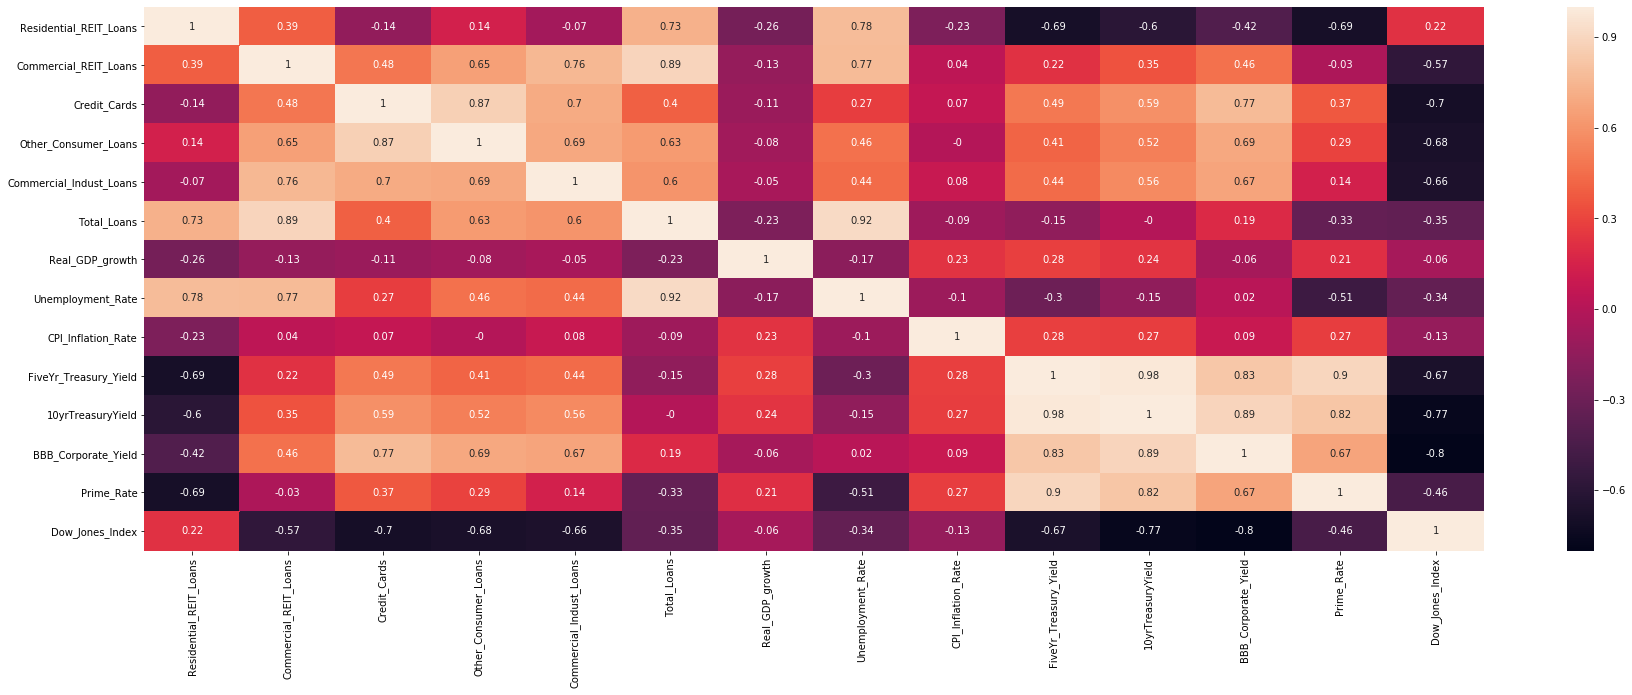

In [2]:
#Next, we create a correlation matrix that measures the relationships between the variables using heatmap function from seaborn lib
cor_matrix = df.corr().round(2)
plt.figure(figsize = (30, 10))
sns.heatmap(data = cor_matrix, annot = True) #annot=True to print the values inside the square

##Multicollinearity
##Correlation matrix is helpful in selecting independent variables. In other words if two independent variable have a high correlation
#to each other, it makes sense to select only one of them.
## For example in our dataset, using both 5 Yr Treasury Rate And 10 yr Treasury Rate may create a problem of multicollinearity as they are 
#strongly correlated. So we will only select one of them.
##Consumer Price Index has a correaltion of below .30 for both Credit Card default rate and Residential defualt rates so we exclude it 
#from our model and same for other correlations below .50

## Also, we can select independent variables to use in our model based on their high correlation to the Dependent variable.
## It will work well when we are selecting one variable. But as we include more vairable, the relationship and correlation will change

##Based on the correlation matrix below we see there is:
# high correlation between default rate of Credit Cards to BBB Corporate Yield (0.77) and Dow Jones Index (-0.70)
# high correlation between default rate of Residential loans to Unemployment Rate (0.78) and 5 yr Treasury Ratio (-0.69)
## So we will use these data points

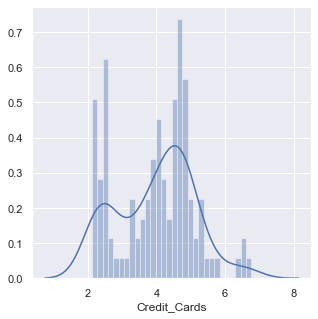

In [3]:
## No distributional assumptions for dependent or independent variables themselves are required.
##It is not necessary that independent or dependent variable be normally distributed
## The requirement is for the residuals of the regression model to be normally distributed.
## But for the sake of just looking at the variables distribtution, we will plot the histograms
##Let’s first plot the distribution of the target variable Credit_Cards. We will use the distplot function from the seaborn library
sns.set(rc={'figure.figsize':(5, 5)})
sns.distplot(df['Credit_Cards'], bins=30) # can also be written as: sns.distplot(price, bins=30)
plt.show()

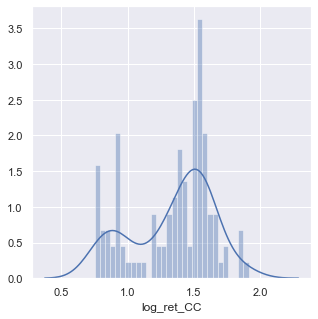

In [4]:
## In the instance when the distribution plot is not normal, procedures like data transformation through square roots, logs etc can be used
## Data transformations can help in producing a more linear relationship with the dependent variable.
# The log transformation can be used to make highly skewed distributions less skewed. This can be valuable both 
#for making patterns in the data more interpretable and for helping to meet the assumptions of inferential statistics.
## Just to show how data can be transformed, we will use an example of log transformation to see if it makes it better
sns.set(rc={'figure.figsize':(5, 5)})
df['log_ret_CC'] = np.log(df['Credit_Cards'])
sns.distplot(df['log_ret_CC'], bins=30)
plt.show()
##In this instance, we don't see any noticeable improvement to our distribution

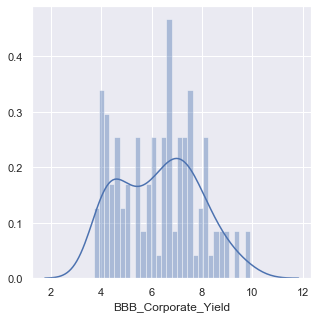

In [5]:
##Next we plot the distribution of BBB Corporate Yield to see its normal distribution
# We will use the distplot function from the seaborn library
sns.set(rc={'figure.figsize':(5, 5)})
sns.distplot(df['BBB_Corporate_Yield'], bins=30) # can also be written as: sns.distplot(price, bins=30)
plt.show()

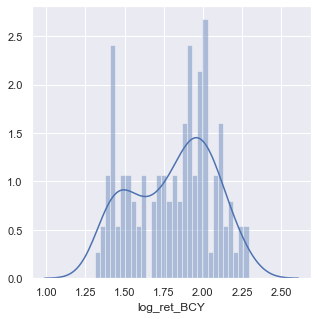

In [6]:
##We will log transfor BBB Corporate yield data as well
df['log_ret_BCY'] = np.log(df['BBB_Corporate_Yield'])
sns.set(rc={'figure.figsize':(5, 5)})
sns.distplot(df['log_ret_BCY'], bins=30) # can also be written as: sns.distplot(price, bins=30)
plt.show()

In [7]:
## We will first look at linear regression model for Credit Card Defaults to BBB Corporate Yield using non-log transformed data
# and then we will compare it with log transformed data to see if we get a better model
CreditCard_Defaults_lm = ols("Credit_Cards ~ BBB_Corporate_Yield", data = df).fit()
CreditCard_Defaults_lm_summary = CreditCard_Defaults_lm.summary()  #summarize our model
print(CreditCard_Defaults_lm_summary)

                            OLS Regression Results                            
Dep. Variable:           Credit_Cards   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     160.1
Date:                Thu, 28 Nov 2019   Prob (F-statistic):           2.52e-23
Time:                        21:15:58   Log-Likelihood:                -123.25
No. Observations:                 114   AIC:                             250.5
Df Residuals:                     112   BIC:                             256.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5418    

In [8]:
## Evalauting the Summary statistics
# TStat for BBB_Corporate_Yield is 12.65 > 1.96 and p-value is 0 <.05 hence vairable is statistically significant.
# Adj R2 is 58.5%, meaning independent variable BBB_Corporate_Yield explains only 58.5% of the variation 
# in the dependent variable Credit Card default. Hence this model does not have a good predictive power.

## We will now use log transformed values for our linear regression model for Credit Card Defaults to BBB Corporate Yield 
CreditCard_Defaults_lm = ols("log_ret_CC ~ log_ret_BCY", data = df).fit()
CreditCard_Defaults_lm_summary = CreditCard_Defaults_lm.summary()  #summarize our model
print(CreditCard_Defaults_lm_summary)

                            OLS Regression Results                            
Dep. Variable:             log_ret_CC   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     229.2
Date:                Thu, 28 Nov 2019   Prob (F-statistic):           7.45e-29
Time:                        21:15:58   Log-Likelihood:                 37.491
No. Observations:                 114   AIC:                            -70.98
Df Residuals:                     112   BIC:                            -65.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.4150      0.117     -3.553      

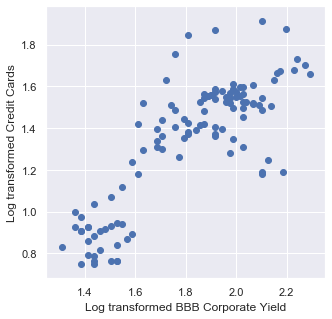

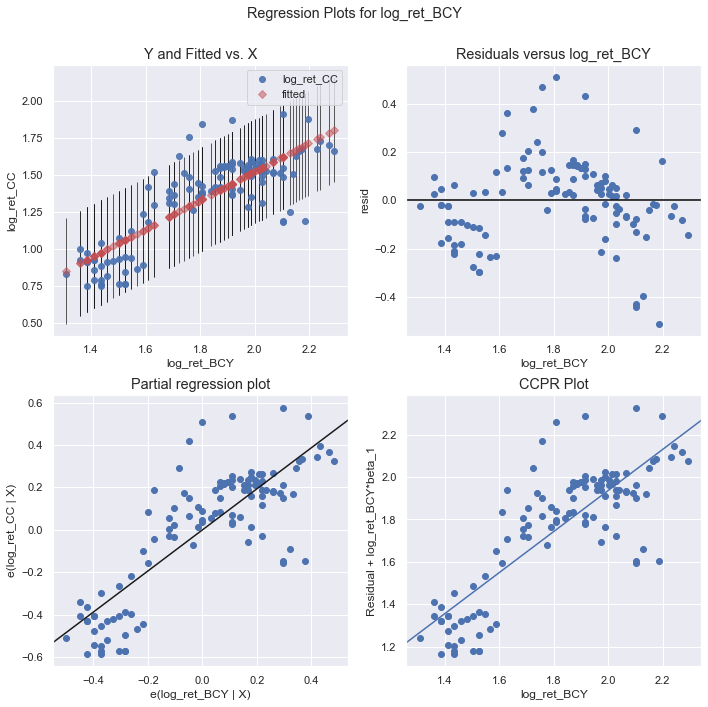

In [9]:
## Evalaution the above Summary statistics of log transformed Credit Card and BBB Corporate Yield regression model
# TStat for log transformed BBB_Corporate_Yield is 15.13 > 1.96 and p-value is 0 <.05 hence vairable is statistically significant.
# Adj R2 has improved and is now 66.9%, meaning independent variable log_ret_BCY explains approx 67% of the variation 
# in the dependent variable Credit Card default. 
## The AIC and BIC numbers are lower at -70.98 and 65.51 compared to previous model at 250 and 256 respectively.
# again pointing to an improved model Hence our currecnt model has a better predictive power than the previous one.

#We can review scatterplots individually in order to see correaltion between target and selected predictor variable
plt.scatter(df.log_ret_BCY, df.log_ret_CC)
plt.xlabel('Log transformed BBB Corporate Yield')
plt.ylabel('Log transformed Credit Cards')
##We can see a positive linear relationship. When the BBB Corporate Yield increases, the Credit Card defaults increase as well

## We will also look at partial regression plots
fig = plt.figure(figsize=(10,10))
# pass in the model as the first parameter, then specify the Predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(CreditCard_Defaults_lm, "log_ret_BCY", fig=fig)

In [10]:
## We will now look at the linear regression model for Residential Loans using predictor variables as Unemployment Rate and 5 Yr Treasury Rate
residential_defaults_lm = ols("Residential_REIT_Loans ~ Unemployment_Rate + FiveYr_Treasury_Yield", data = df).fit()
residential_defaults_lm_summary = residential_defaults_lm.summary()  #summarize our model
print(residential_defaults_lm_summary)

                              OLS Regression Results                              
Dep. Variable:     Residential_REIT_Loans   R-squared:                       0.828
Model:                                OLS   Adj. R-squared:                  0.825
Method:                     Least Squares   F-statistic:                     267.8
Date:                    Thu, 28 Nov 2019   Prob (F-statistic):           3.35e-43
Time:                            21:16:00   Log-Likelihood:                -186.56
No. Observations:                     114   AIC:                             379.1
Df Residuals:                         111   BIC:                             387.3
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000233C4065550>,
      dtype=object)

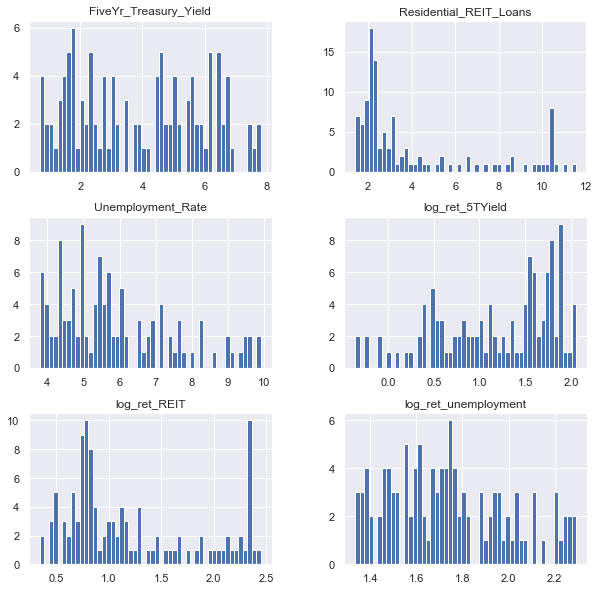

In [11]:
## Next we will log transform all our dependent and independent variable and take a look at their normal distribution plots
df['log_ret_REIT'] = np.log(df['Residential_REIT_Loans']) # log transform Residential_REIT_Loans
df['log_ret_unemployment'] = np.log(df['Unemployment_Rate']) # log transform Unemployment_Rate
df['log_ret_5TYield'] = np.log(df['FiveYr_Treasury_Yield']) # log transform iveYr_Treasury_Yield

##From our original dataframe df which contained all variable initially, we will drop the ones that we are not using as our variables
df_modified = df.drop(['Commercial_REIT_Loans', 'Credit_Cards', 'log_ret_CC', 'BBB_Corporate_Yield', 'log_ret_BCY', 'Total_Loans', 'Dow_Jones_Index', 
                    'Real_GDP_growth','Other_Consumer_Loans', 'Commercial_Indust_Loans', 'CPI_Inflation_Rate', '10yrTreasuryYield', 'Prime_Rate'], axis=1)

## our df_modified contains a new dataframe with only the variables we would be using to look at the histograms
df_modified.hist(bins=50, figsize=(10, 10))

In [12]:
## We will now look at the linear regression model for Residential Loans to Unemployment Rate and 5 Yr Treasury Rate 
##using thier log transformed data
residential_defaults_lm = ols("log_ret_REIT ~ log_ret_unemployment + log_ret_5TYield", data = df).fit()
residential_defaults_lm_summary = residential_defaults_lm.summary()  #summarize our model
print(residential_defaults_lm_summary)

                            OLS Regression Results                            
Dep. Variable:           log_ret_REIT   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     206.6
Date:                Thu, 28 Nov 2019   Prob (F-statistic):           3.87e-38
Time:                        21:16:02   Log-Likelihood:                -19.450
No. Observations:                 114   AIC:                             44.90
Df Residuals:                     111   BIC:                             53.11
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0168 

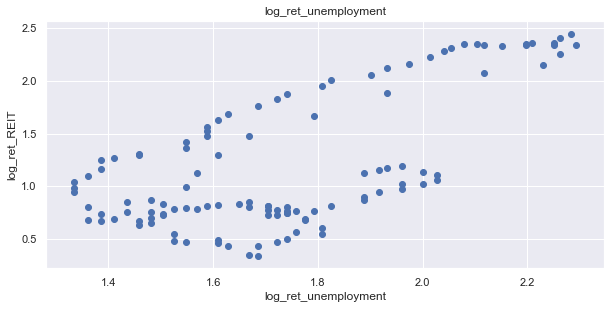

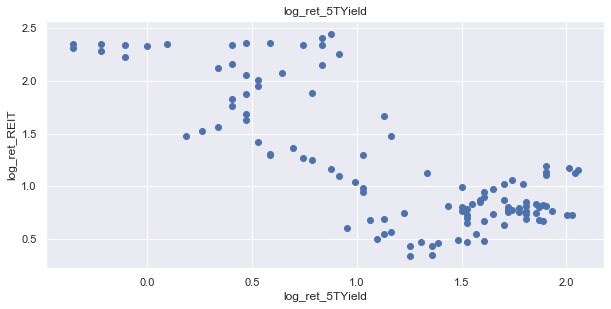

In [13]:
## Evalaution the above Summary statistics
# TStat for log_ret_unemployment is 9.89 > 1.96 and p-value is 0 <.05 hence vairable is statistically significant.
# Abs value of TStat for log_ret_5TYield is 13.16 > 1.96 and p-value is 0 <.05 hence vairable is statistically significant.
# Coefficient for log_ret_unemployment is +1.11 meaning when unemployment goes up, the residential loan defaults go up
# which is intuitively correct. Coefficient for log_ret_5TYield is -.60 meaning when 5 yr Treasury yield goes up, the residential loan 
# default rate goes down, which intuitively does not seem right. It shows an inverse realtionship between them albeit very small.
## This maybe explained by the logic that usually when the economy does well, fed tends to increase the interest rates thereby
# increasing short term and long term 5 yr and 10 yr treasury rates. In a good economy residentials defaults certainly don't go up.
# Adj R2 has decresed in our model from previous 82.5% to 78.4%. But if our model explains 78.4% of the variation dependent variable then its
# still a good model
## The AIC and BIC numbers went lower from 379 and 387 to 44.9 and 53.1 respectively, signalling an improved model.

## We can plot scatterplots simultaneously in order to see correaltion between Price and selected predictor variable
target = df_modified['log_ret_REIT']
features_names = ['log_ret_unemployment','log_ret_5TYield']  # List of variable names to be used for df[]
for i, col_name in enumerate(features_names):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, len(features_names)/2 , i+1)
    plt.scatter(df_modified[col_name], target, marker='o')
    plt.title(col_name)
    plt.xlabel(col_name)
    plt.ylabel('log_ret_REIT')

Text(0, 0.5, 'Residuals')

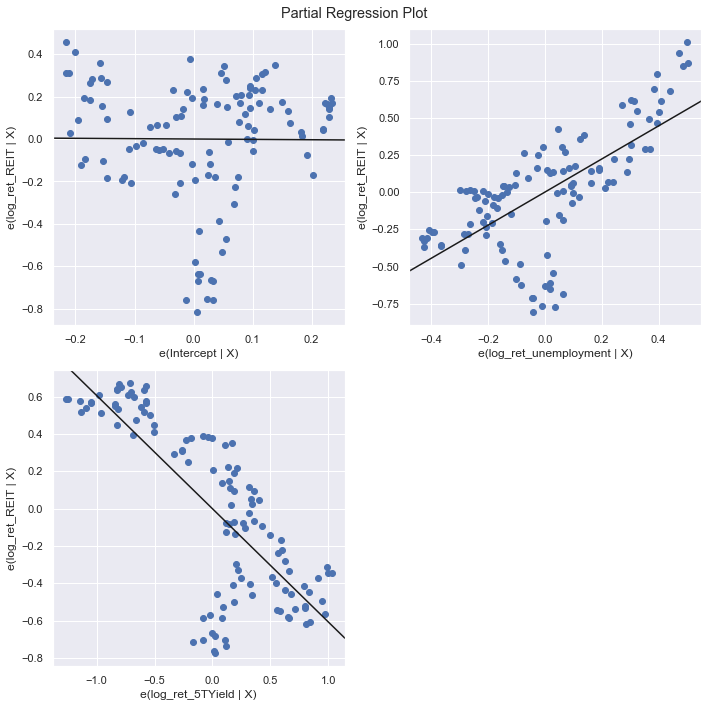

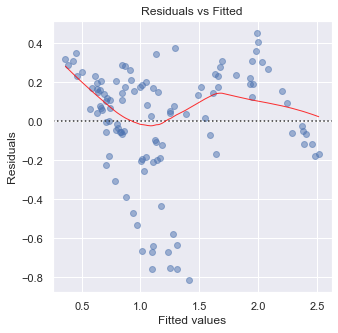

In [14]:
#this produces our partial regression plots
fig = plt.figure(figsize=(10,10))
fig = sm.graphics.plot_partregress_grid(residential_defaults_lm, fig=fig)

##Create Residual plot
features = df_modified.drop(['Residential_REIT_Loans', 'Unemployment_Rate', 'FiveYr_Treasury_Yield'], axis=1)

dfresiduals = pd.concat([features, target], axis=1)
model_fitted_y = residential_defaults_lm.fittedvalues
model_residuals = residential_defaults_lm.resid

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, model_residuals, data = dfresiduals, lowess=True, scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')